In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm
from datetime import datetime

sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('ts_data.csv')
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3352 entries, 0 to 3351
Data columns (total 13 columns):
avg_temp         3352 non-null float64
avg_real_feel    3352 non-null float64
avg_prec_val     3352 non-null float64
date             3352 non-null datetime64[ns]
count            3352 non-null float64
hour             3352 non-null int64
dayofweek        3352 non-null int64
quarter          3352 non-null int64
month            3352 non-null int64
year             3352 non-null int64
dayofyear        3352 non-null int64
dayofmonth       3352 non-null int64
weekofyear       3352 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 340.6 KB


In [4]:
df.head()

,avg_temp,avg_real_feel,avg_prec_val,date,count,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,17.4,18.6,0.0,2019-04-20 12:00:00,102.0,12,5,2,4,2019,110,20,16
1,18.7,19.6,0.0,2019-04-20 13:00:00,122.0,13,5,2,4,2019,110,20,16
2,19.4,19.9,0.0,2019-04-20 14:00:00,90.0,14,5,2,4,2019,110,20,16
3,18.6,18.7,0.0,2019-04-20 15:00:00,75.0,15,5,2,4,2019,110,20,16
4,17.9,17.7,0.0,2019-04-20 16:00:00,74.0,16,5,2,4,2019,110,20,16


In [5]:
df.shape

(3352, 13)

In [6]:
X = df.drop(['date'], axis=1).copy()

### Clustering

In [7]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(X) for i in tqdm(n_cluster)]
scores = [kmeans[i].score(X) for i in range(len(kmeans))]

100%|██████████| 19/19 [00:11<00:00,  1.70it/s]


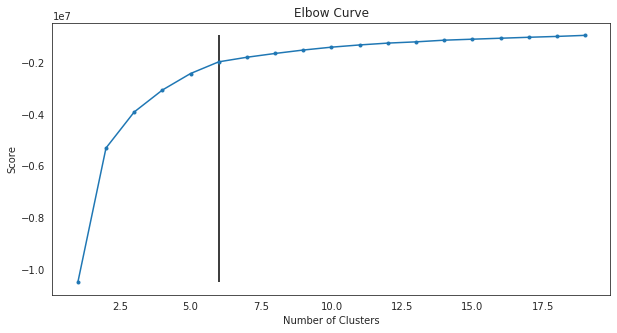

In [8]:
plt.figure(figsize=(10,5))
plt.plot(n_cluster, scores, marker='.')
plt.vlines(6, min(scores), max(scores))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [9]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
cluster = kmeans.predict(X);

In [10]:
def getDistanceByPoint(df, model):
    distance = pd.Series()
    for i in range(0,len(df)):
        Xa = np.array(df.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05
distance = getDistanceByPoint(X, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly'] = (distance >= threshold).astype(int)
df['cluster'] = cluster

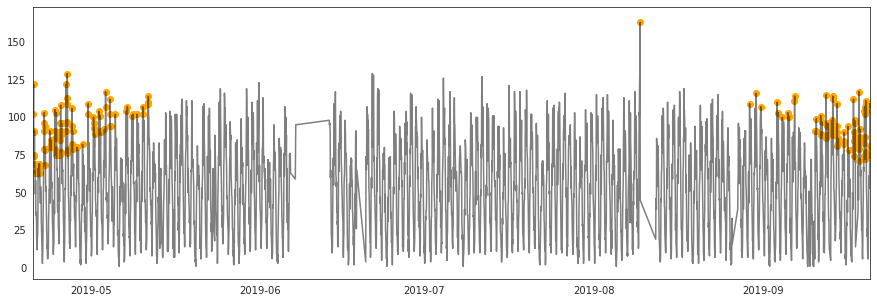

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df['date'], df['count'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==True]['date'], df[df['anomaly']==True]['count'], c='orange')
plt.xlim((df['date'].min(), df['date'].max()));

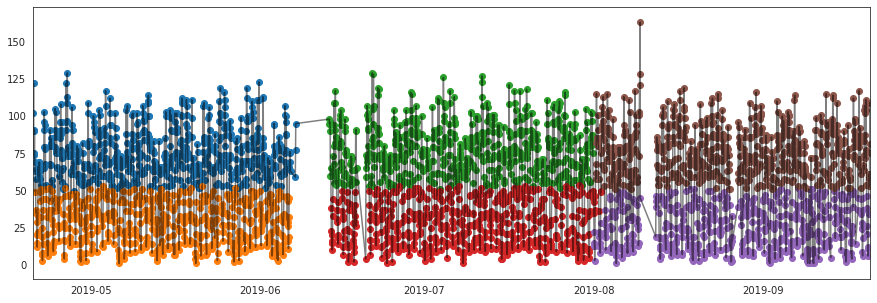

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(df['date'], df['count'], c='k', alpha=0.5)
for i in df['cluster'].unique():
    plt.scatter(df[df['cluster']==i]['date'], df[df['cluster']==i]['count'])
plt.xlim((df['date'].min(), df['date'].max()));


### Isolation Forest

In [21]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).copy()
ifor =  IsolationForest(contamination=0.05)
ifor.fit(X_scaled) 
df['anomaly'] = ifor.predict(X_scaled)

/home/paula/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [1]:
plt.figure(figsize=(15, 5))
plt.plot(df['date'], df['count'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==-1]['date'], df[df['anomaly']==-1]['count'], c='orange')
plt.xlim((df['date'].min(), df['date'].max()));

NameError: name 'plt' is not defined